# Convolution NN for first break picking

## Content
* [Problem description](#Problem-description)
* [Datasets](#Datasets)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Running time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)

## Problem description

First-break picking is the task of determining, given a set of raw seismic traces, the onsets of the first signal arrivals as accurately as possible. The accurate determination of the first arrivals onset first-break times is needed for calculating the static corrections, a fundamental stage of seismic data processing.

## Datasets

We exploit raw traces from Pal dataset as training examples. We will test our model on the Pal traces from seismofields, the model did not see during training. Besides, we validate our model on the traces from WZ dataset, completely different terrain, in order to find out whether the model is capable to find first break pattern at specific locality only or mathes the pattern generally. Both datasets descriptions are avaliable [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

| Filename | About this file | Size | N ffid | Length |
| :------ | ----: | ----: | ----: | ----: |
| Pal_Flatiron_1k.sgy | Raw field seismogram | 2.5 Gb | 1001 | 1.4 s |
| Pal_Flatiron_1k_picking.csv | First break time | 16 Mb | 1001 | - |

| Filename | About this file | Size | N ffid | Length |
| :------ | ----: | ----: | ----: | ----: |
| WZ_Flatiron_1k.sgy | Raw field seismogram | 2.4 Gb | 1001 | 1.4 s |
| WZ_Flatiron_1k_picking.csv | First break time | 16 Mb | 1001 | - |

In [1]:
import sys
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V, F
from seismicpro.batchflow.models.torch import UNet

from seismicpro.src import SeismicBatch, FieldIndex, TraceIndex, seismic_plot, CustomIndex
from seismicpro.src.utils import PickingMetrics

In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
markup_path = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

In [3]:
batch = (Dataset(index, SeismicBatch).next_batch(batch_size=1)
        .load(components='raw', fmt='segy')
        .load(components='markup', fmt='picks'))

Draw seismogram and 10 first traces with labeled picking.

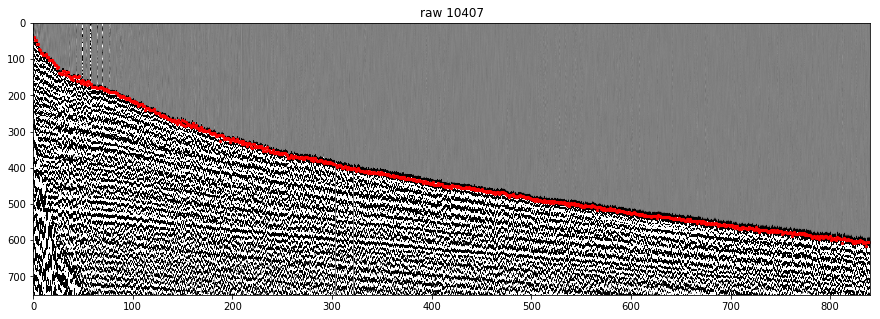

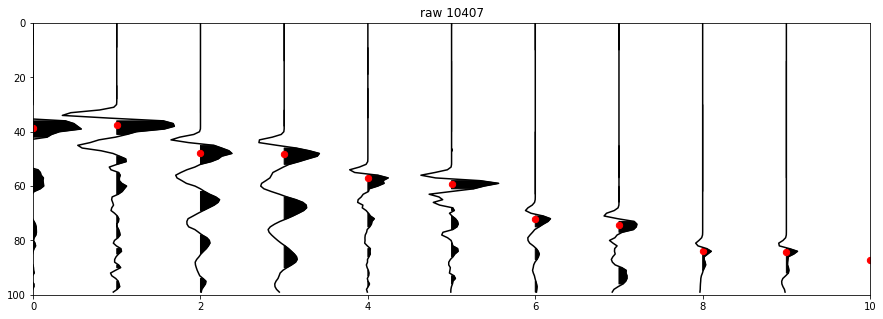

In [4]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, c='r')
      .seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                    figsize=(15,5), vmax=cv, vmin=-cv, s=40, c='r', wiggle=True, xlim=(0,10), ylim=(0,100), std=0.01))

Set train and test fields

In [5]:
train_index = index.create_subset(index.indices[:10])
train_data = Dataset(TraceIndex(train_index), SeismicBatch)

In [6]:
test_index = index.create_subset(index.indices[10:20])
test_data = Dataset(TraceIndex((test_index)), SeismicBatch)

## Model Architecture

We are using 1D Unet type of model with 4 blocks

In [7]:
inputs_config = {
    'raw': {'shape': (1, 753)}, 
    'mask': {'shape': (1, 753),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

In [8]:
%env CUDA_VISIBLE_DEVICES=4
config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head/num_classes': 2, 
    'body/num_blocks': 4,
    'body/filters': [8, 16, 32, 64], 
    'body/encoder': dict(layout='cna cna', kernel_size=5),
    'body/decoder': dict(layout='cna cna', kernel_size=5),
    'device': 'cuda',
}

env: CUDA_VISIBLE_DEVICES=4


## Hyperparameters estimation(to do)

See the [research notebook](https://github.com/analysiscenter/SeismicPro/blob/supervised_picking/models/First_break_picking/research.ipynb) for investigation of model parameters influence on the model performance.

## Training

Training pipeline actions:   
* Load raw traces and labels.
* Drop the traces from the batch which consist of lots of zeros.
* Normalize the traces to the zero mean and unit variance.
* Convert labeled picking to the mask for futher pixel-wise classification.
* Preprocess the batch of traces to make it compatible with torch models.

Training process:
* Optimizer: Adam, learning rate 0.01
* Batch size: 64, n_epochs: 10

In [10]:
train_pipeline = (train_data.p
                      .init_model('dynamic', UNet, 'my_model', config=config)
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .normalize_traces(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .preprocess_torch_input(src=['raw', 'mask'], dst=['raw', 'mask'])
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss', mode='a')))

Run the train pipeline.

In [11]:
train_pipeline.run(batch_size=64, n_iters=1000, shuffle=True, drop_last=True, bar=True)

100%|██████████| 1000/1000 [03:03<00:00,  5.46it/s]


Loss function plot

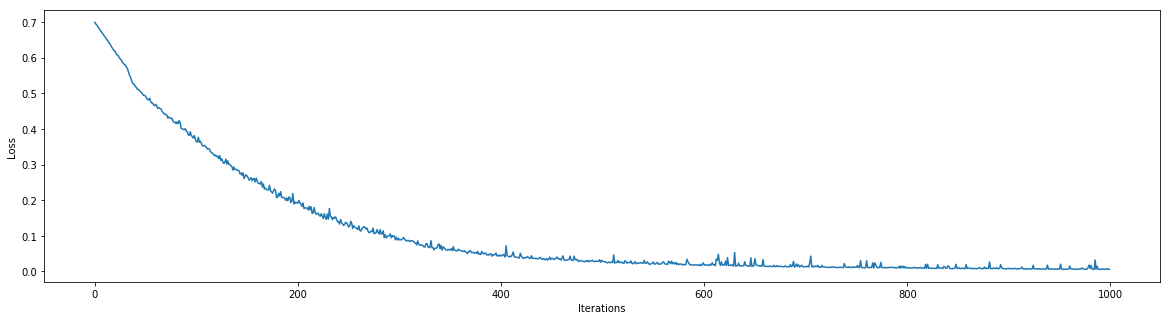

In [12]:
loss = train_pipeline.get_variable('loss')
plt.figure(figsize=(20, 5))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.plot(loss)

Save the model.

In [12]:
train_pipeline.save_model_now('my_model', path='model_1d.dill')

## Inference

Inference pipeline:

In [30]:
model_path = "model_1d.dill"
config_predict = {
    'build': False,
    'load': {'path': model_path},
    'device': 'cuda'
}

test_pipeline = (Pipeline()
                      .init_model('dynamic', UNet, 'my_model', config=config_predict) 
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .normalize_traces(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .add_components(components='unet_predictions')
                      .preprocess_torch_input(src=['raw', 'mask'], dst=['raw', 'mask'])
                      .predict_model('my_model', B('raw'), fetches='predictions',
                                       save_to=B('unet_predictions', mode='a'))
                      .init_variable('picking', init_on_each_run=list())
                      .update_variable('picking', B('mask'), mode='a')
                      .init_variable('traces', init_on_each_run=list())
                      .update_variable('traces', B('raw'), mode='a')
                      .mask_to_pick(src='unet_predictions', dst='unet_predictions', labels=False)
                      .init_variable('predictions', init_on_each_run=list())
                      .update_variable('predictions', B('unet_predictions'), mode='a')
                      .dump(src='unet_predictions', fmt='picks',path='model_predictions.csv', traces='raw', to_samples=True))

Run pipeline on the whole dataset.   
Model results dumped to the file **model_predictions.csv**.

In [31]:
(test_pipeline << test_data).run(1000, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 92%|█████████▏| 12/13 [00:08<00:00,  1.41it/s]


## Running time

System config:
* GPU: GTX GeForce 1080
* CPU(s): 40
* Model name: Intel Xeon E5-2630

Time performance:
* Single model training iteration with batch size=64: 0.18 sec.
* Inference of 1000 traces: 0.67 sec.

## Model evaluation

We evaluate the metrics of model perfomance on two different datasets.

### Dataset 1

In [32]:
pred = np.hstack(np.concatenate(test_pipeline.get_variable('predictions')))
true = np.argmax(np.vstack(test_pipeline.get_variable('picking')), axis=1)
raw = np.vstack(np.concatenate(test_pipeline.get_variable('traces')))

Take a look at the metrics.   

In [33]:
metrics = PickingMetrics(true, pred, gap=3)

MAE stands for Mean Absolute Error - how much model picking deviates from ground trurh on the avarage in absolute terms

In [34]:
print('MAE on dataset 1 validation: {0:.3f}'.format(metrics.evaluate('mae')))

MAE on dataset 1 validation: 261.932


Even though picking is a regression task, we can consider its classification interpretation.   
If ground truth and model picking differs on 3 or more in absolute terms - we consider such trace as not properly classified.

In [35]:
print('Accuracy on dataset 1 validation: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on dataset 1 validation: 49.86%


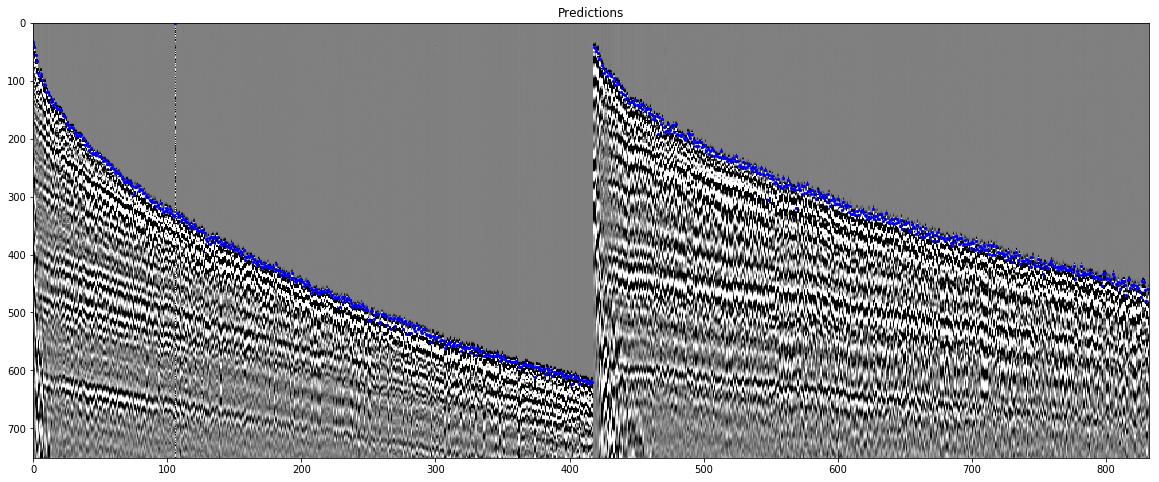

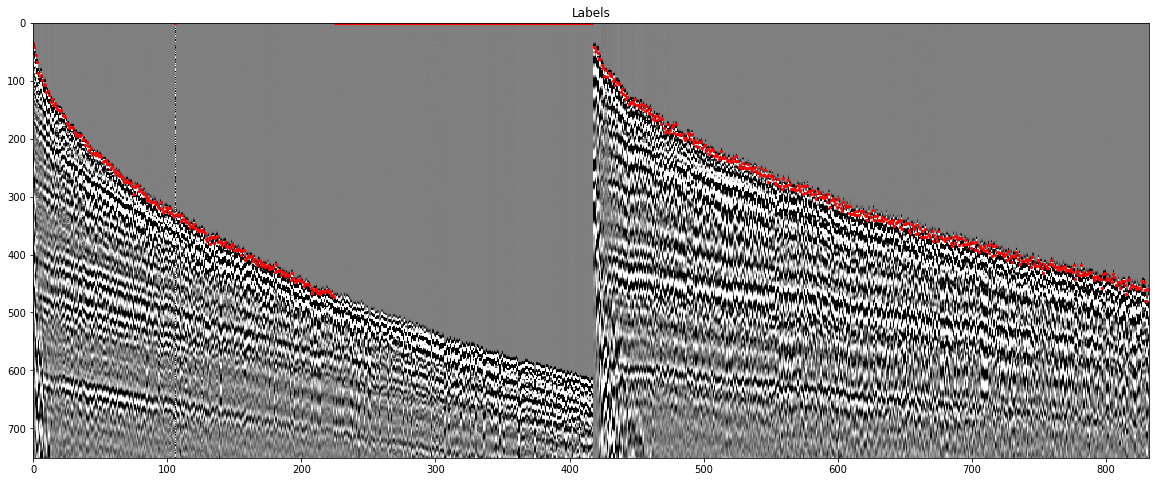

In [36]:
ind = range(832)
cv = 1
pts = (range(len(pred[ind])), pred[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 5, c = 'b', figsize=(20, 8), names=['Predictions'])

pts = (range(len(true[ind])), true[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 5, c = 'r', figsize=(20, 8), names=['Labels'])

### Dataset 2 evaluation

Same steps for dataset 2.

Set the paths to SEG files and labeled picking.

In [37]:
path_raw = '/notebooks/egor/FB/WZ/WZ_Flatiron_1k.sgy'
markup_path='/notebooks/egor/FB/WZ/WZ_Flatiron_1k_picking.csv'

Load 10 seismofields for model evaluation.

In [38]:
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)
test_index = index.create_subset(index.indices[:20])
test_data = Dataset(TraceIndex((test_index)), SeismicBatch)

Run inference pipeline.

In [39]:
(test_pipeline << test_data).run(500, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 96%|█████████▌| 24/25 [00:10<00:00,  2.30it/s]


Skip the traces with negative labels of picking.

In [40]:
true = np.argmax(np.vstack(test_pipeline.get_variable('picking')), axis=1)
mask = true > 0

In [41]:
pred = np.hstack(np.concatenate(test_pipeline.get_variable('predictions')))[mask]
raw = np.vstack(np.concatenate(test_pipeline.get_variable('traces')))[mask]
true = true[mask]

Take a look at the metrics on dataset 2.

In [42]:
metrics = PickingMetrics(true, pred)

In [43]:
print('MAE on dataset 2 validation: {0:.3f}'.format(metrics.evaluate('mae')))

MAE on dataset 2 validation: 1.945


In [44]:
print('Accuracy on dataset 2 validation: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on dataset 2 validation: 93.83%


Plot whole seismogram.

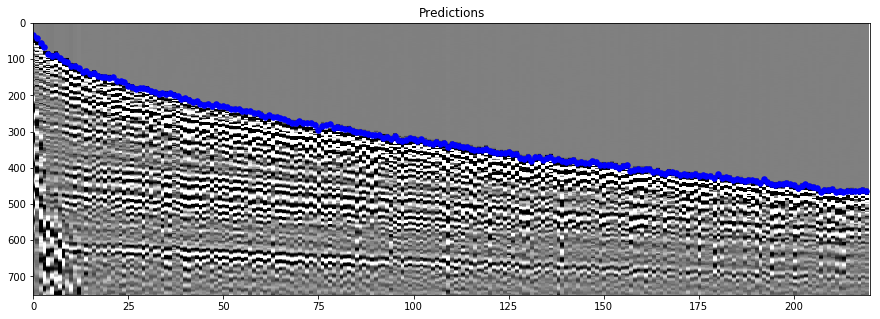

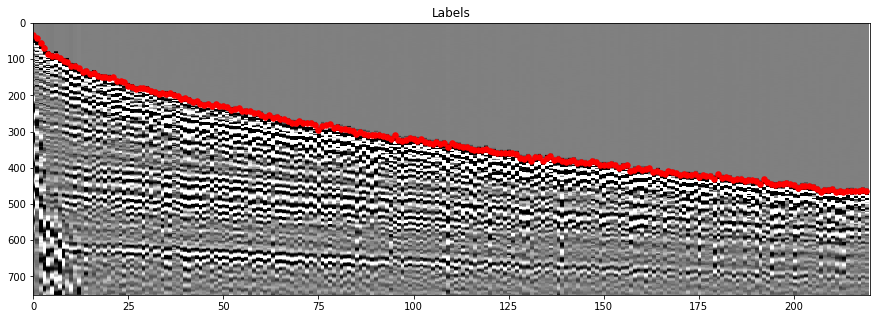

In [45]:
ind = range(220)
cv = 1
pts = (range(len(pred[ind])), pred[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 30, c = 'b', figsize=(15, 5), names=['Predictions'])

pts = (range(len(true[ind])), true[ind])
seismic_plot(raw[ind], cmap='gray',vmax=cv, vmin=-cv, pts=pts, s = 30, c = 'r', figsize=(15, 5), names=['Labels'])

## Criticism

### 10 most poorly predicted traces

Take a look at 10 traces where the model mistakes the most.

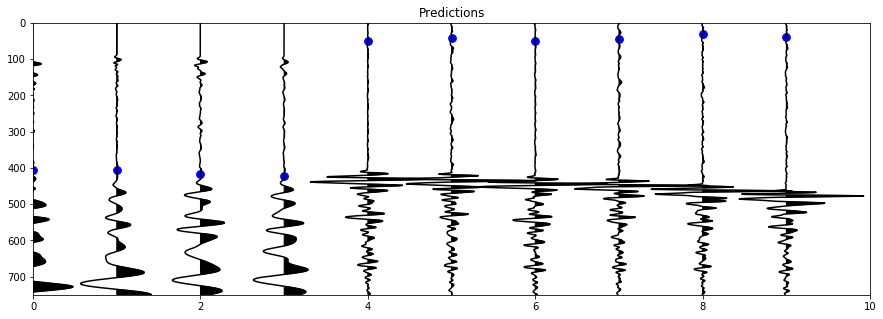

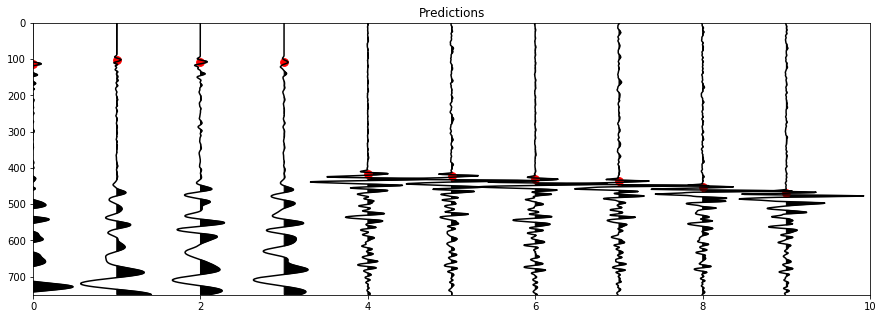

In [46]:
difference = abs(true-pred)
worst = difference.argsort()[-10:]
ylim = (0, 750)
s = 60
std = 0.1
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(pred[worst])), pred[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, c='b', std = std, ylim=ylim, names=['Predictions'])
seismic_plot(raw[worst], cmap='gray', wiggle=True, pts=(range(len(true[worst])), true[worst]), vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, c='r', std = std, ylim=ylim, names=['Predictions'])

### Worst predicted trace and its direct neighboors

Take a closer look at the "worst trace" and its neighboors.   
There is a trace with significant level of noise, which forces the model to mistake.

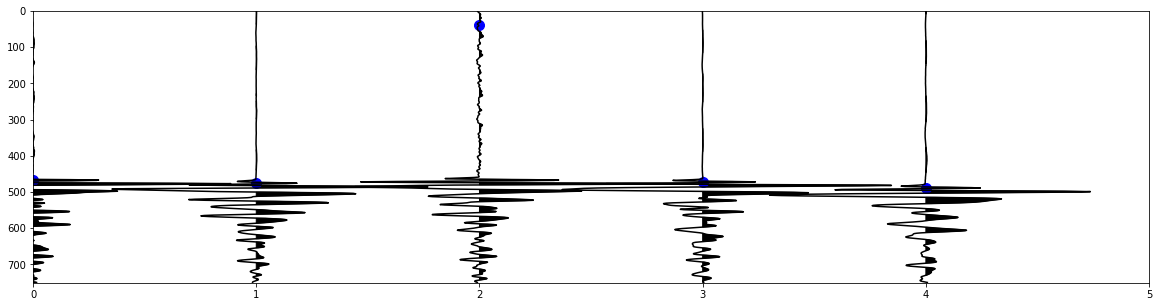

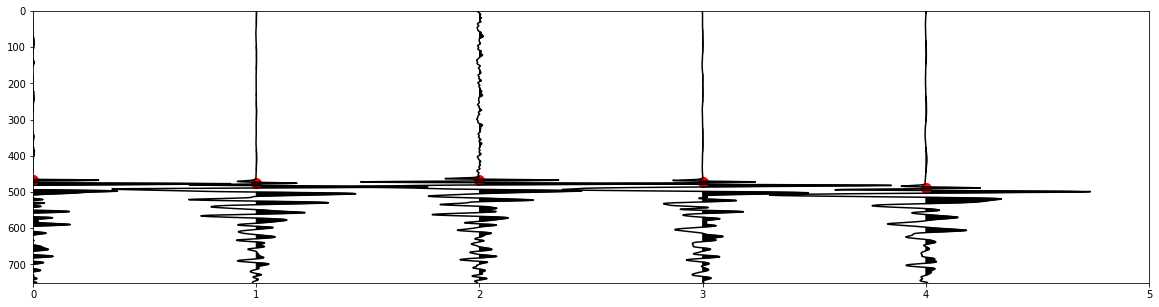

In [47]:
k = 9
nworst = [worst[k] - 2, worst[k] - 1, worst[k], worst[k] + 1, worst[k] + 2]
ylim = (min(np.concatenate((true[nworst], pred[nworst]))) - 10, max(np.concatenate((true[nworst], pred[nworst]))) + 100)
s = 100
std = 0.1
seismic_plot((raw[nworst]), cmap='gray', wiggle=True, pts=(range(len(pred[nworst])), pred[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, c='b', std = std)
seismic_plot(raw[nworst], cmap='gray', wiggle=True, pts=(range(len(true[nworst])), true[nworst]), vmax=cv, cmin=-cv,
             figsize=(20, 5), s = s, c='r', std = std)

## Conclusion

The model finds first break picking, but it quite sencitive to the traces with the significant noise amplitudes before signal.   
The model generalises the pattern of first break picking and shows decent results in  valudation on traces from completely different terrain rather than training ones.   
However, not always correct ground truth labels and noise in the signal is two main challenges in this task.